In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import pandas as pd
from tqdm import tqdm

In [ ]:
class MultiArmedBandit:
    """A k-armed bandit problem with normally distributed rewards."""
    
    def __init__(self, k: int = 10, seed: Optional[int] = None):
        """
        Initialize a k-armed bandit.
        
        Args:
            k: Number of arms
            seed: Random seed for reproducibility
        """
        self.k = k
        self.rng = np.random.RandomState(seed)
        self.reset()
    
    def reset(self):
        """Reset the bandit with new true action values."""
        # True action values q*(a) are selected from N(0, 1)
        self.q_true = self.rng.randn(self.k)
        self.best_action = np.argmax(self.q_true)
        
    def step(self, action: int) -> float:
        """
        Take an action and receive a reward.
        
        Args:
            action: The action to take (0 to k-1)
            
        Returns:
            reward: The reward received (sampled from N(q*(a), 1))
        """
        return self.rng.randn() + self.q_true[action]


class EpsilonGreedyAgent:
    """Agent using epsilon-greedy action selection with sample-average estimates."""
    
    def __init__(self, k: int, epsilon: float, initial_q: float = 0.0, 
                 alpha: Optional[float] = None, seed: Optional[int] = None):
        """
        Initialize an epsilon-greedy agent.
        
        Args:
            k: Number of actions
            epsilon: Probability of exploration
            initial_q: Initial action-value estimates
            alpha: Step size (None for sample averages)
            seed: Random seed
        """
        self.k = k
        self.epsilon = epsilon
        self.initial_q = initial_q
        self.alpha = alpha
        self.rng = np.random.RandomState(seed)
        self.reset()
    
    def reset(self):
        """Reset the agent's estimates and counts."""
        self.q_estimates = np.ones(self.k) * self.initial_q
        self.n_actions = np.zeros(self.k)
        self.total_steps = 0
        
    def select_action(self) -> int:
        """
        Select an action using epsilon-greedy policy.
        
        Returns:
            action: Selected action
        """
        if self.rng.rand() < self.epsilon:
            # Explore: random action
            return self.rng.randint(self.k)
        else:
            # Exploit: greedy action (random tiebreaking)
            max_q = np.max(self.q_estimates)
            greedy_actions = np.where(self.q_estimates == max_q)[0]
            return self.rng.choice(greedy_actions)
    
    def update(self, action: int, reward: float):
        """
        Update action-value estimate.
        
        Args:
            action: Action that was taken
            reward: Reward received
        """
        self.n_actions[action] += 1
        self.total_steps += 1
        
        if self.alpha is None:
            # Sample average: alpha = 1/n
            alpha = 1.0 / self.n_actions[action]
        else:
            # Constant step size
            alpha = self.alpha
            
        # Update Q-value estimate: Q(a) <- Q(a) + alpha * [R - Q(a)]
        self.q_estimates[action] += alpha * (reward - self.q_estimates[action])


class GradientBanditAgent:
    """Agent using gradient-based action selection (REINFORCE for bandits)."""
    
    def __init__(self, k: int, learning_rate: float, use_baseline: bool = True, 
                 seed: Optional[int] = None):
        """
        Initialize a gradient bandit agent.
        
        Args:
            k: Number of actions
            learning_rate: Learning rate (alpha)
            use_baseline: Whether to use average reward as baseline
            seed: Random seed
        """
        self.k = k
        self.learning_rate = learning_rate
        self.use_baseline = use_baseline
        self.rng = np.random.RandomState(seed)
        self.reset()
    
    def reset(self):
        """Reset the agent's preferences and baseline."""
        self.h_preferences = np.zeros(self.k)  # Action preferences H(a)
        self.avg_reward = 0.0  # Running average reward (baseline)
        self.total_steps = 0
        
    def get_action_probabilities(self) -> np.ndarray:
        """
        Compute action probabilities using softmax.
        
        Returns:
            probabilities: Probability of each action
        """
        # Softmax: pie(a) = exp(H(a)) / sum_b exp(H(b))
        # Subtract max for numerical stability
        h_stable = self.h_preferences - np.max(self.h_preferences)
        exp_h = np.exp(h_stable)
        return exp_h / np.sum(exp_h)
    
    def select_action(self) -> int:
        """
        Select an action according to the softmax probabilities.
        
        Returns:
            action: Selected action
        """
        probabilities = self.get_action_probabilities()
        return self.rng.choice(self.k, p=probabilities)
    
    def update(self, action: int, reward: float):
        """
        Update preferences using gradient ascent.
        
        Args:
            action: Action that was taken
            reward: Reward received
        """
        self.total_steps += 1
        
        # Update baseline (running average)
        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.total_steps
            baseline = self.avg_reward
        else:
            baseline = 0.0
        
        # Compute action probabilities
        probabilities = self.get_action_probabilities()
        
        # Update preferences
        # H(a) <- H(a) + alpha(R - baseline)(1 - pie(a)) for selected action
        # H(a') <- H(a') - alpha(R - baseline)pie(a') for all other actions
        for a in range(self.k):
            if a == action:
                self.h_preferences[a] += self.learning_rate * (reward - baseline) * (1 - probabilities[a])
            else:
                self.h_preferences[a] -= self.learning_rate * (reward - baseline) * probabilities[a]


In [ ]:
def run_experiment(agent_class, n_bandits: int = 2000, n_steps: int = 1000, **agent_kwargs) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run experiment with multiple bandits.
    
    Args:
        agent_class: Agent class to use
        n_bandits: Number of bandit problems to average over
        n_steps: Number of steps per bandit
        **agent_kwargs: Arguments for agent initialization
        
    Returns:
        avg_rewards: Average reward at each step
        pct_optimal: Percentage of optimal actions at each step
    """
    rewards = np.zeros((n_bandits, n_steps))
    optimal_actions = np.zeros((n_bandits, n_steps))
    
    for i in tqdm(range(n_bandits), desc=f"Running {agent_class.__name__}"):
        bandit = MultiArmedBandit(k=10, seed=i)
        agent = agent_class(k=10, seed=i*100, **agent_kwargs)
        
        for t in range(n_steps):
            # Select action, get reward, update agent, record results
            action = agent.select_action()
            reward = bandit.step(action)
            agent.update(action, reward)
            rewards[i, t] = reward
            optimal_actions[i, t] = (action == bandit.best_action)
    
    # Average over all bandits
    avg_rewards = np.mean(rewards, axis=0)
    pct_optimal = np.mean(optimal_actions, axis=0) * 100
    
    return avg_rewards, pct_optimal

In [ ]:
# Run experiments 
print("Running experiments")

# Original epsilon-greedy experiments
results = {}

# ε = 0.1 (blue in original)
print("Running ε=0.1...")
avg_r, pct_opt = run_experiment(EpsilonGreedyAgent, epsilon=0.1)
results['ε=0.1'] = {'rewards': avg_r, 'optimal': pct_opt}

# ε = 0.01 (red in original)
print("Running ε=0.01...")
avg_r, pct_opt = run_experiment(EpsilonGreedyAgent, epsilon=0.01)
results['ε=0.01'] = {'rewards': avg_r, 'optimal': pct_opt}

# ε = 0 (greedy, green in original)
print("Running ε=0 (greedy)...")
avg_r, pct_opt = run_experiment(EpsilonGreedyAgent, epsilon=0.0)
results['ε=0 (greedy)'] = {'rewards': avg_r, 'optimal': pct_opt}

print("\nRunning gradient bandit experiments...")

# No baseline, α = 0.1
print("Running gradient bandit: no baseline, α=0.1...")
avg_r, pct_opt = run_experiment(GradientBanditAgent, learning_rate=0.1, use_baseline=False)
results['Gradient α=0.1 (no baseline)'] = {'rewards': avg_r, 'optimal': pct_opt}

# No baseline, α = 0.4
print("Running gradient bandit: no baseline, α=0.4...")
avg_r, pct_opt = run_experiment(GradientBanditAgent, learning_rate=0.4, use_baseline=False)
results['Gradient α=0.4 (no baseline)'] = {'rewards': avg_r, 'optimal': pct_opt}

# With baseline, α = 0.1
print("Running gradient bandit: with baseline, α=0.1...")
avg_r, pct_opt = run_experiment(GradientBanditAgent, learning_rate=0.1, use_baseline=True)
results['Gradient α=0.1 (baseline)'] = {'rewards': avg_r, 'optimal': pct_opt}

# With baseline, α = 0.4
print("Running gradient bandit: with baseline, α=0.4...")
avg_r, pct_opt = run_experiment(GradientBanditAgent, learning_rate=0.4, use_baseline=True)
results['Gradient α=0.4 (baseline)'] = {'rewards': avg_r, 'optimal': pct_opt}

Running experiments for Figure 2.2 reproduction...
Running ε=0.1...


Running EpsilonGreedyAgent: 100%|██████████| 2000/2000 [00:25<00:00, 77.04it/s]


Running ε=0.01...


Running EpsilonGreedyAgent: 100%|██████████| 2000/2000 [00:26<00:00, 74.88it/s]


Running ε=0 (greedy)...


Running EpsilonGreedyAgent: 100%|██████████| 2000/2000 [00:26<00:00, 75.39it/s]



Running gradient bandit experiments...
Running gradient bandit: no baseline, α=0.1...


Running GradientBanditAgent: 100%|██████████| 2000/2000 [01:02<00:00, 32.04it/s]


Running gradient bandit: no baseline, α=0.4...


Running GradientBanditAgent: 100%|██████████| 2000/2000 [01:02<00:00, 31.91it/s]


Running gradient bandit: with baseline, α=0.1...


Running GradientBanditAgent: 100%|██████████| 2000/2000 [01:02<00:00, 31.81it/s]


Running gradient bandit: with baseline, α=0.4...


Running GradientBanditAgent: 100%|██████████| 2000/2000 [01:02<00:00, 32.17it/s]


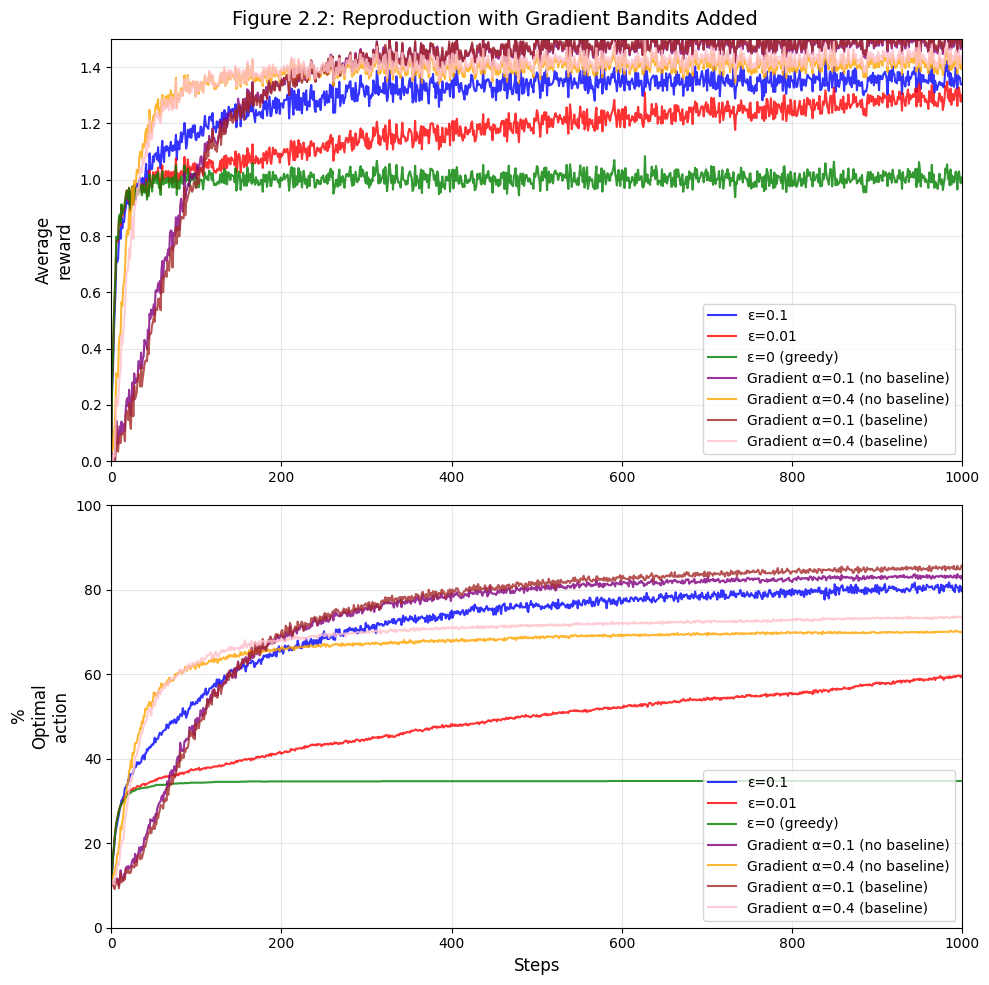


Final Performance Summary (at step 1000):
------------------------------------------------------------
ε=0.1                               | Reward: 1.339 | Optimal: 79.7%
ε=0.01                              | Reward: 1.301 | Optimal: 59.6%
ε=0 (greedy)                        | Reward: 1.008 | Optimal: 34.8%
Gradient α=0.1 (no baseline)        | Reward: 1.493 | Optimal: 83.3%
Gradient α=0.4 (no baseline)        | Reward: 1.417 | Optimal: 70.0%
Gradient α=0.1 (baseline)           | Reward: 1.502 | Optimal: 85.8%
Gradient α=0.4 (baseline)           | Reward: 1.437 | Optimal: 73.6%


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

colors = {
    'ε=0.1': 'blue',
    'ε=0.01': 'red', 
    'ε=0 (greedy)': 'green',
    'Gradient α=0.1 (no baseline)': 'purple',
    'Gradient α=0.4 (no baseline)': 'orange',
    'Gradient α=0.1 (baseline)': 'brown',
    'Gradient α=0.4 (baseline)': 'pink'
}

# Plot of average rewards
for method, data in results.items():
    ax1.plot(data['rewards'], color=colors[method], label=method, alpha=0.8)

ax1.set_ylabel('Average\nreward', fontsize=12)
ax1.set_xlim(0, 1000)
ax1.set_ylim(0, 1.5)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right')

# Plot % optimal action
for method, data in results.items():
    ax2.plot(data['optimal'], color=colors[method], label=method, alpha=0.8)

ax2.set_xlabel('Steps', fontsize=12)
ax2.set_ylabel('%\nOptimal\naction', fontsize=12)
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right')

plt.suptitle('Figure 2.2: Reproduction with Gradient Bandits Added', fontsize=14)
plt.tight_layout()
plt.show()

# Print final performance summary
print("\nFinal Performance Summary (at step 1000):")
print("-" * 60)
for method, data in results.items():
    final_reward = data['rewards'][-1]
    final_optimal = data['optimal'][-1]
    print(f"{method:35s} | Reward: {final_reward:.3f} | Optimal: {final_optimal:.1f}%")